In [1]:
#Import all necessay modules.  The ScrapeNBAData is a module I wrote, and includes a DrawCourt module which was written by P. Giampa.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import ScrapeNBAData

## This is a simple analysis of how the spacing and pace of the NBA offence's has changed over the last 2 decades.

We will
1. collect and clean data from basketball-reference.com,
2. look at the average points per game, FGA per game, 3PA per game, and shooting distances for teams,
3. we will examine changes in  Stephan Curry and Damian Lillard's shot selection over that time.



## Collecting and cleaning data

In [2]:
teamData = []
for idx, season in enumerate(range(2002,2025)):
    teamData.append(ScrapeNBAData.getTeamData(season))
    #print(season)
    for df in range(len(teamData[idx])):
        teamData[idx][df]['Year'] =  ([season]*len(teamData[idx][df]))

In [3]:
#new column names for shooting dataframes, Valid up to 2016
newShootingColumnNames = [
    'Rk',
    'Team',
    'G',
    'MP',
    'FG%',
    'Dist',
    'Toss',
    '% of FGA by dist:2p',
    '% of FGA by dist:0-3',
    '% of FGA by dist:3-10',
    '% of FGA by dist:10-16',
    '% of FGA by dist:16-3P',
    '% of FGA by dist:3P',
    'Toss',
    'FG% by dist:2p',
    'FG% by dist:0-3',
    'FG% by dist:3-10',
    'FG% by dist:10-16',
    'FG% by dist:16-3P',
    'FG% by dist:3P',
    'Toss',
    '% of FG Assisted:2P',
    '% of FG Assisted:3P',
    'Toss',
    'Dunks:%FGA',
    'Dunks:Made',
    'Toss',
    'Layups:%FGA',
    'Layups:Made',
    'Toss',
    'Corner:%3PA',
    'Corner:3P%',
    'Toss',
    'Heaves:Att',
    'Heaves:Made',
    'Year'
    ]

In [4]:
# Organizing data
seasons_list = []

for season in range(len(teamData)):
    # Get standings, wins, and losses, 
    # Need to combine eastern and western conference standings
    teamData[season][1].columns = teamData[season][0].columns
    df_standings = pd.concat([teamData[season][0], teamData[season][1]])
    df_standings = df_standings[df_standings['W'].astype(str).str.contains('Division') == False]
    df_standings = df_standings.rename(columns={'Eastern Conference':'Team'})
    df_standings = df_standings.sort_values(by=['Team'])
    df_standings = df_standings.reset_index(drop = True)
    df_standings = df_standings.dropna()

    ## Get team stats and concat all data frames, remove duplicates 
    ## For year == 2001:2015 
        #Team it is df[][4]; for year == 2016: it is df[][6]
        #Shooting it is df[][9]; for year == 2016: it is df[][11]
    if teamData[season][9]['Year'][0] < 2016:
        team = 4
        shooting = 9
    else:
        team = 6
        shooting = 11

    #Team totals
    teamData[season][team] = teamData[season][team].sort_values(by=['Team'])
    teamData[season][team] = teamData[season][team].reset_index(drop=True)

    # Team shooting stats
    teamData[season][shooting] = teamData[season][shooting].set_axis(newShootingColumnNames, axis =1)
    teamData[season][shooting] = teamData[season][shooting].loc[:,~teamData[season][shooting].columns.duplicated()].copy()
    teamData[season][shooting] = teamData[season][shooting].drop('Toss', axis = 1)
    teamData[season][shooting] = teamData[season][shooting].reset_index(drop=True)
    teamData[season][shooting] = teamData[season][shooting].dropna()

    df_team = pd.concat([df_standings, teamData[season][team], teamData[season][shooting]], axis = 1)
    df_team = df_team.loc[:,~df_team.columns.duplicated()].copy()

    # Change data types for correlation matrix
    for metric in ['W', 'L', 'W/L%', 'PS/G', 'PA/G', 'SRS']:
        df_team[metric] = pd.to_numeric(df_team[metric])

    df_team['Corner:3PMd'] = df_team['Corner:3P%'] * df_team['3PA'] * df_team['Corner:%3PA']
    #print(teamData[season][9]['Year'][0])
    seasons_list.append(df_team)

In [5]:
# List column headers, data we can choose from.
seasons_list[19].columns

Index(['Team', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS', 'Year', 'Rk',
       'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Dist', '% of FGA by dist:2p', '% of FGA by dist:0-3',
       '% of FGA by dist:3-10', '% of FGA by dist:10-16',
       '% of FGA by dist:16-3P', '% of FGA by dist:3P', 'FG% by dist:2p',
       'FG% by dist:0-3', 'FG% by dist:3-10', 'FG% by dist:10-16',
       'FG% by dist:16-3P', 'FG% by dist:3P', '% of FG Assisted:2P',
       '% of FG Assisted:3P', 'Dunks:%FGA', 'Dunks:Made', 'Layups:%FGA',
       'Layups:Made', 'Corner:%3PA', 'Corner:3P%', 'Heaves:Att', 'Heaves:Made',
       'Corner:3PMd'],
      dtype='object')

# NBA offences
Lets start by looking at the average points scored by a team, by season

In [6]:
## The seasons we are looking at.
x_years = []
for season in range(len(seasons_list)):
    x_years.append(seasons_list[season].Year[0])

Text(0.5, 1.0, 'Team points per game')

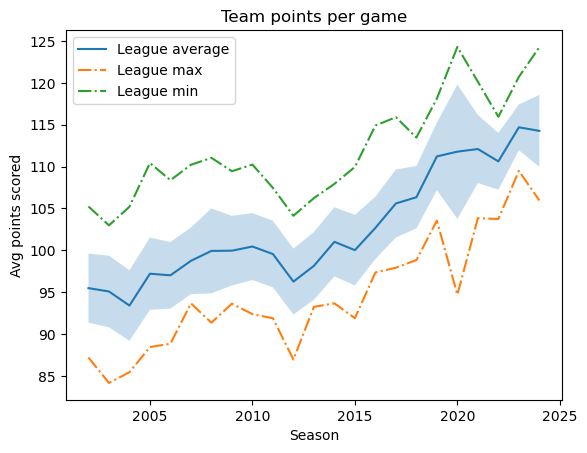

In [7]:
## Plot the points per game, 1=std spread, and the min and max  
y_pts, y_pts_sigma, y_pts_min, y_pts_max = [], [],  [], [] 

for season in range(len(seasons_list)):
    y_pts.append(seasons_list[season]['PTS'].mean()/ seasons_list[season]['G'].mean())
    y_pts_sigma.append(seasons_list[season]['PTS'].std()/ seasons_list[season]['G'].mean())
    y_pts_min.append(seasons_list[season]['PTS'].min()/ seasons_list[season]['G'].mean())
    y_pts_max.append(seasons_list[season]['PTS'].max()/ seasons_list[season]['G'].mean())

plt.figure()
plt.plot(x_years, y_pts, label = 'League average')
plt.fill_between(x_years, np.subtract(y_pts, y_pts_sigma), np.add(y_pts, y_pts_sigma), alpha = 0.25)
plt.plot(x_years, y_pts_min, label = 'League max', linestyle = 'dashdot')
plt.plot(x_years, y_pts_max, label = 'League min', linestyle = 'dashdot')

plt.legend()
plt.xlabel('Season')
plt.ylabel('Avg points scored')
plt.title('Team points per game')

## Scoring is clearly up, but why?
The average NBA team now scores almost 20 points per game more than in 2001.  
The most likely explanation is increase in pace and frequency of 3-point shooting.

Let's examine this by plotting FGA per game by season, and average shot distance by season.

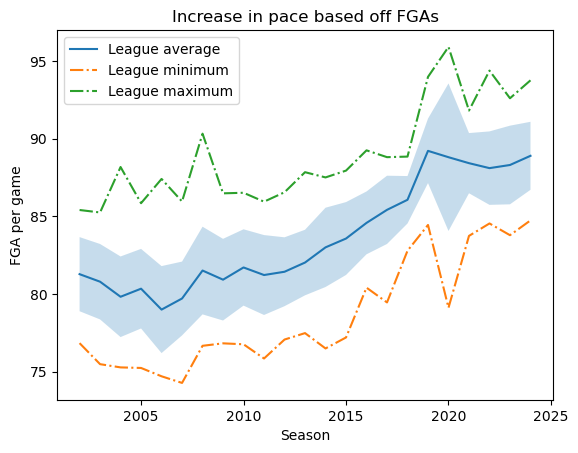

In [8]:
fga_g, fga_g_std, fga_g_min, fga_g_max = [], [], [], []
for season in range(len(seasons_list)):
    fga_g.append(seasons_list[season]['FGA'].mean()/ seasons_list[season]['G'].mean())
    fga_g_std.append(seasons_list[season]['FGA'].std()/ seasons_list[season]['G'].mean())
    fga_g_min.append(seasons_list[season]['FGA'].min()/ seasons_list[season]['G'].mean())
    fga_g_max.append(seasons_list[season]['FGA'].max()/ seasons_list[season]['G'].mean())

fig, ax1 = plt.subplots()

ax1.plot(x_years, fga_g, fillstyle= 'none',  label = 'League average')
ax1.fill_between(x_years, np.subtract(fga_g, fga_g_std), np.add(fga_g, fga_g_std), alpha = 0.25)
ax1.plot(x_years, fga_g_min, label = 'League minimum', linestyle = 'dashdot')
ax1.plot(x_years, fga_g_max, label = "League maximum", linestyle = 'dashdot')
ax1.set_ylabel('FGA per game')
ax1.set_xlabel('Season')
ax1.set_title("Increase in pace based off FGAs")
ax1.legend()

plt.show()

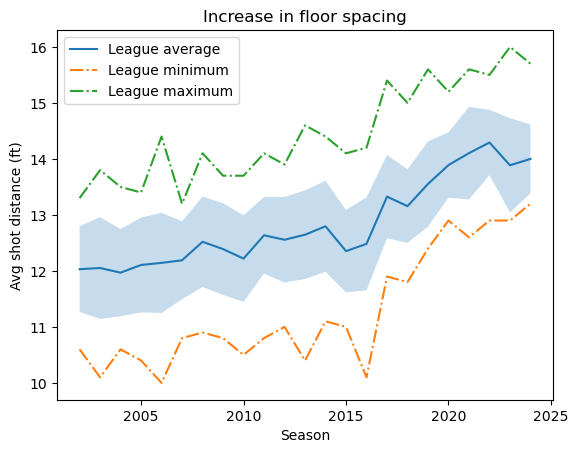

In [9]:
dist, dist_std, dist_min, dist_max = [], [], [], []
for season in range(len(seasons_list)):
    dist.append(seasons_list[season]['Dist'].mean())
    dist_std.append(seasons_list[season]['Dist'].std())
    dist_min.append(seasons_list[season]['Dist'].min())
    dist_max.append(seasons_list[season]['Dist'].max())

fig, ax1 = plt.subplots()
ax1.plot(x_years, dist, label = "League average")
ax1.fill_between(x_years, np.subtract(dist, dist_std), np.add(dist, dist_std), alpha = 0.25)
ax1.plot(x_years, dist_min, label = 'League minimum', linestyle = 'dashdot')
ax1.plot(x_years, dist_max, label = "League maximum", linestyle = 'dashdot')
ax1.set_ylabel('Avg shot distance (ft)')
ax1.set_xlabel('Season')
ax1.set_title('Increase in floor spacing')
ax1.legend()

plt.show()


## Increase in pace and shot distance
It is clear that teams today take more shots per game than before.  It is also clear that the average shot distance has increased. But this does not indicate more 3PA per game.  We can break down the FGA by distance.

In [10]:
y_perct_of_0_3, y_perct_of_0_3_std= [],[]
y_perct_of_3_10, y_perct_of_3_10_std = [],[]
y_perct_of_10_16, y_perct_of_10_16_std = [],[]
y_perct_of_16_3P, y_perct_of_16_3P_std = [],[]
y_perct_of_3P,y_perct_of_3P_std  = [],[]

for season in range(len(seasons_list)):
    y_perct_of_0_3.append(seasons_list[season]['% of FGA by dist:0-3'].mean())
    y_perct_of_3_10.append(seasons_list[season]['% of FGA by dist:3-10'].mean()) 
    y_perct_of_10_16.append(seasons_list[season]['% of FGA by dist:10-16'].mean())
    y_perct_of_16_3P.append(seasons_list[season]['% of FGA by dist:16-3P'].mean())
    y_perct_of_3P.append(seasons_list[season]['% of FGA by dist:3P'].mean())
    y_perct_of_0_3_std.append(seasons_list[season]['% of FGA by dist:0-3'].std())
    y_perct_of_3_10_std.append(seasons_list[season]['% of FGA by dist:3-10'].std()) 
    y_perct_of_10_16_std.append(seasons_list[season]['% of FGA by dist:10-16'].std())
    y_perct_of_16_3P_std.append(seasons_list[season]['% of FGA by dist:16-3P'].std())
    y_perct_of_3P_std.append(seasons_list[season]['% of FGA by dist:3P'].std())
 


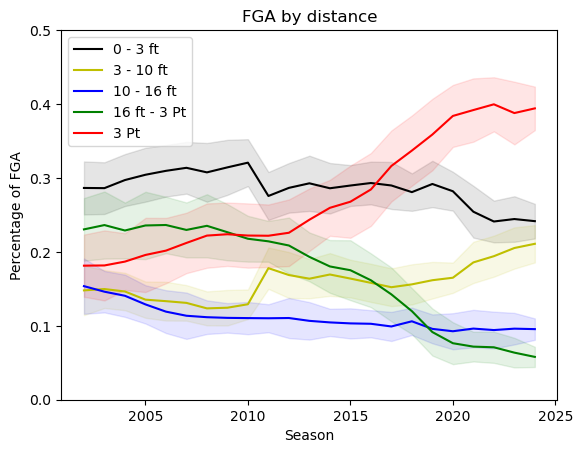

In [11]:
plt.figure()
plt.plot(x_years, y_perct_of_0_3, 'k', label = '0 - 3 ft',)
plt.plot(x_years, y_perct_of_3_10, 'y', label = '3 - 10 ft',)
plt.plot(x_years, y_perct_of_10_16, 'b', label = '10 - 16 ft',)
plt.plot(x_years, y_perct_of_16_3P, 'g', label = '16 ft - 3 Pt',)
plt.plot(x_years, y_perct_of_3P, 'r', label = '3 Pt', )

plt.fill_between(x_years, np.subtract(y_perct_of_0_3, y_perct_of_0_3_std), np.add(y_perct_of_0_3, y_perct_of_0_3_std), alpha = 0.1, color = 'k')
plt.fill_between(x_years, np.subtract(y_perct_of_3_10, y_perct_of_3_10_std), np.add(y_perct_of_3_10, y_perct_of_3_10_std), alpha = 0.1, color = 'y')
plt.fill_between(x_years, np.subtract(y_perct_of_10_16, y_perct_of_10_16_std), np.add(y_perct_of_10_16, y_perct_of_10_16_std), alpha = 0.1, color = 'b')
plt.fill_between(x_years, np.subtract(y_perct_of_16_3P, y_perct_of_16_3P_std), np.add(y_perct_of_16_3P, y_perct_of_16_3P_std), alpha = 0.1, color = 'g')
plt.fill_between(x_years, np.subtract(y_perct_of_3P, y_perct_of_3P_std), np.add(y_perct_of_3P, y_perct_of_3P_std), alpha = 0.1, color = 'r')

plt.ylim(0, .5)
plt.legend()
plt.title("FGA by distance")
plt.ylabel("Percentage of FGA")
plt.xlabel("Season")
plt.show()

## More 3PA!
This plot clearly shows an increase in 3PA in today's offences, as seen by the rapid increase in the red line. The average takes almost double the number of 3PA today that 20 years ago. There is also a steady decline in long 2's (green line). In 2001, the average number of 3PA per team was around 15.5 a game. In 2024, that number has climbed to almost 35, more than double.

It is interesting to note the yellow line. The increase in these shots is possibly due to more spread offences combined with high pick-and-rolls straight down to the basket.  This action can open the defence up to more short floaters.  Additionally, many teams utilize the dunkers spot in their offence now.  The analysis of this is left for another day.

## Are there just more shots, or has shooting gotten better in the NBA?
Let's plot the average 3P% for each team by season to examine this question.

In [12]:
y_3Pperc_g, y_3Pperc_g_std= [], []
y_3Pperc_g_min, y_3Pperc_g_max = [],[]

for season in range(len(seasons_list)):
    y_3Pperc_g.append(seasons_list[season]['3P%'].mean())
    y_3Pperc_g_std.append(seasons_list[season]['3P%'].std())
    y_3Pperc_g_min.append(seasons_list[season]['3P%'].min())
    y_3Pperc_g_max.append(seasons_list[season]['3P%'].max())

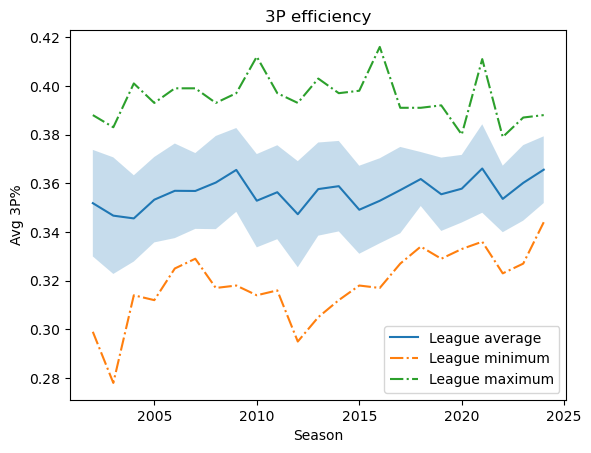

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(x_years, y_3Pperc_g, label = "League average")
ax1.fill_between(x_years, np.subtract(y_3Pperc_g, y_3Pperc_g_std), np.add(y_3Pperc_g, y_3Pperc_g_std), alpha = 0.25)
ax1.plot(x_years, y_3Pperc_g_min, label = 'League minimum', linestyle = 'dashdot')
ax1.plot(x_years, y_3Pperc_g_max, label = "League maximum", linestyle = 'dashdot')
ax1.set_ylabel('Avg 3P%')
ax1.set_xlabel('Season')
ax1.set_title('3P efficiency')
ax1.legend()

plt.show()

The data shows that average 3P shooting efficiency has not gotten significantly better over the last 25 years (blue line).  Thus, the increase in scoring is coming from a faster pace, and more 3PA. However, the worst-shooting teams have definitely closed the game (orange line)

## Corner 3's
The corner 3 is the shortest 3P field goal a player can attempt.  Placing shooters at the corner 3 position also allows the offence to spread the floor at allow ball handlers more room to operate.  We can plot the increase in corner 3's

In [14]:
y_corner3att_g, y_corner3att_g_std  = [], []
y_corner_3PMd_g, y_corner_3PMd_g_std= [], []
y_Corr_W_3att, y_Corr_W_3md = [], []
y_Corr_W_pts, y_Corr_W_3PA = [], [],


for season in range(len(seasons_list)):
    #y_Corr_W_pts.append(seasons_list[season]['W'].corr(seasons_list[season]['PTS']))
    #y_Corr_W_3PA.append(seasons_list[season]['W'].corr(seasons_list[season]['3PA']))
    #y_Corr_W_3att.append(seasons_list[season][(seasons_list[season].W > 60 ) | (seasons_list[season].W < 25 )]
    #                     ['PTS'].corr(seasons_list[season]['Corner:%3PA']))
    y_Corr_W_3md.append(seasons_list[season][(seasons_list[season].W > 60 ) | (seasons_list[season].W < 25 )]
                        ['PTS'].corr(seasons_list[season]['Corner:3PMd']))
    y_corner3att_g.append(seasons_list[season]['Corner:%3PA'].mean() * seasons_list[season]['3PA'].mean() / seasons_list[season]['G'].mean())
    y_corner_3PMd_g.append(seasons_list[season]['Corner:3PMd'].mean()/ seasons_list[season]['G'].mean())
    y_corner3att_g_std.append(seasons_list[season]['Corner:%3PA'].std() * seasons_list[season]['3PA'].mean() / seasons_list[season]['G'].mean())
    y_corner_3PMd_g_std.append(seasons_list[season]['Corner:3PMd'].std()/ seasons_list[season]['G'].mean())
    
    


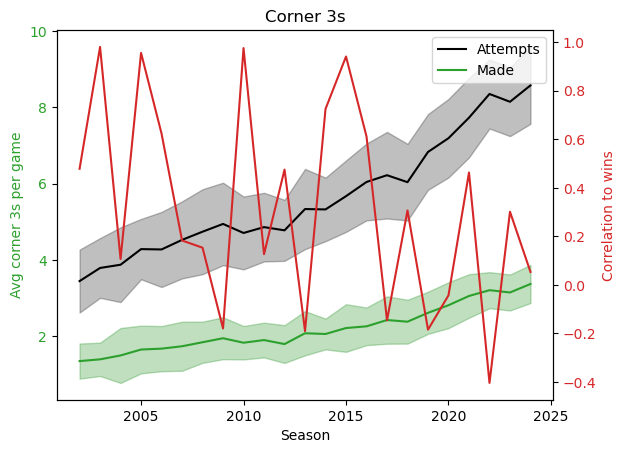

In [15]:
fig, ax = plt.subplots()

color = 'tab:green'
ax.set_title('Corner 3s')
ax.set_xlabel("Season")
ax.plot(x_years, y_corner3att_g, color = 'k', label = 'Attempts')
ax.fill_between(x_years, np.subtract(y_corner3att_g, y_corner3att_g_std), np.add(y_corner3att_g,y_corner3att_g_std), color = 'k', alpha = .25)
ax.plot(x_years, y_corner_3PMd_g, color = color, label = 'Made')
ax.fill_between(x_years, np.subtract(y_corner_3PMd_g, y_corner_3PMd_g_std), np.add(y_corner_3PMd_g,y_corner_3PMd_g_std), color = 'g', alpha = .25)
ax.set_ylabel('Avg corner 3s per game', color = color)
ax.tick_params(axis = 'y', labelcolor = color)

color = 'tab:red'
ax2 = ax.twinx()
ax2.plot(x_years,y_Corr_W_3md, color = color,)
ax2.set_ylabel('Correlation to wins', color = color)
ax2.tick_params(labelcolor = color)

ax.legend()


The number of corner 3's attempted has almost tripled (black line) in the last 25 years, going from roughly 3.5 a game to just under 9.  This is more than the average increase in total 3PA taken by a team.  However, as we saw earlier, 3P shooting efficiency remains about the same, and yet we don't see 3-fold increase in corner 3's made (green line).  

The red line indicates the correlation of corner 3's made to wins. As there is a large variance, only teams with more than 60 wins, or less than 25 are considered.  This data still has a large variance, however, it is interesting to note that on at least 4 different occasions, there was an almost perfect correlation of corner 3's made to wins.  This deserves a more detailed study. 

There are two possible explanations that come to my mind and are worth investigating.  Firstly, many of these corner 3's might be taken later in the shot clock with the shooters being rushed to shoot.  Secondly, offences might bury poor shooters in the corners to take advantage of the shorter distance.
The analysis of both of these questions is left for a difference analysis sheet.

# Individual shooting
Let's look at the shooting evolution of a great shooter, Stephan Curry.

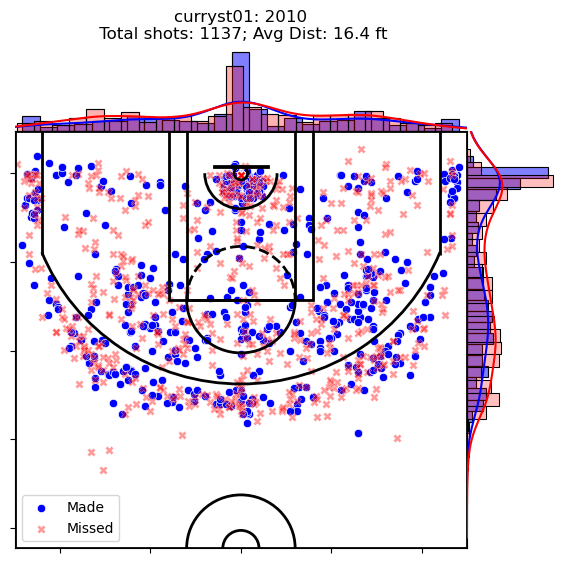

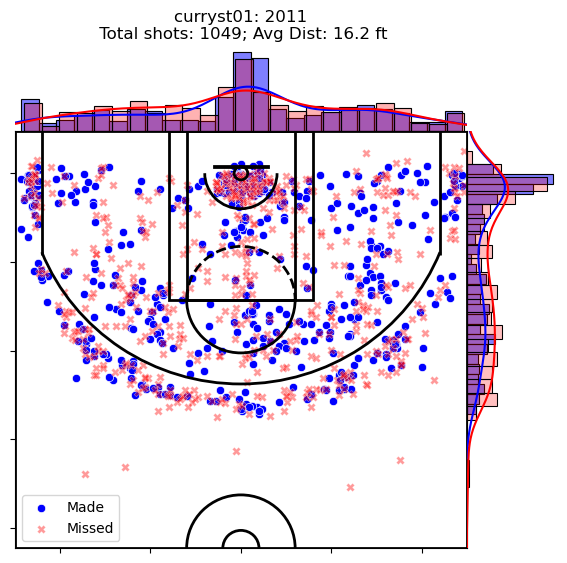

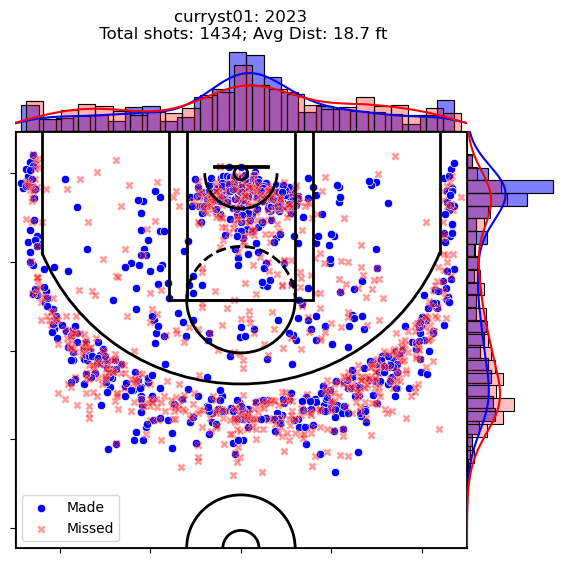

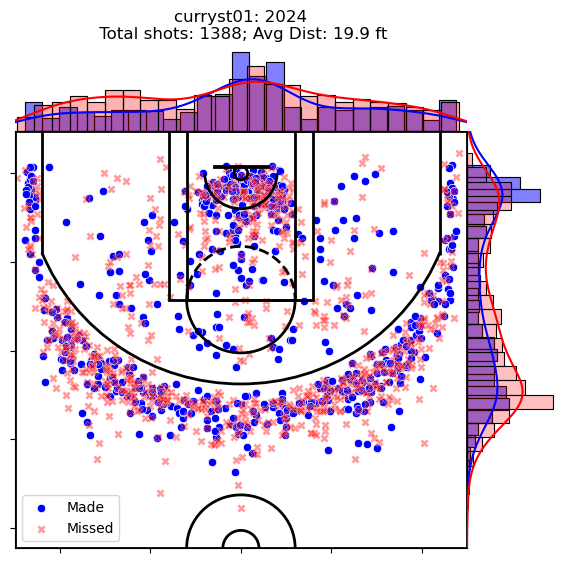

<module 'matplotlib.pyplot' from '/home/ssidhu/miniconda3/envs/dataScience/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [16]:
curry = 'curryst01'
ScrapeNBAData.plotIndividualShotChart(curry, 2010, 25, 25)
ScrapeNBAData.plotIndividualShotChart(curry, 2011, 25, 25)
ScrapeNBAData.plotIndividualShotChart(curry, 2023, 25, 25)
ScrapeNBAData.plotIndividualShotChart(curry, 2024, 25, 25)

It is interesting to note that early in Curry's career, he shot many long 2s, and his average shot distance was roughly 16 ft.  Contract that to this current season, his average shot distance is roughly 20 ft, almost 4 feet further out.
Notice also that in 2024 he shot more lay ups and short floaters. Early in his career, he shot very few short floaters.  This aligns with the increase in the percentage 3-10 ft shots taken across the NBA that we saw earlier.

# Conclusion
1. There is an increase in scoring in the NBA.  The average team scores roughly 20 points per game more now than 25 years ago.
2. This increase has come from an increase in pace, the average team takes roughly 8 more shots from the field per game now compared to 25 years ago.
3. During that time, there has been a near doubling in 3-point field goal attempts per game. Each team used to take 15.5 3=point shots a game, and now they take almost 35.
4. There has not been a drastic increase in 3 point shooting efficiency, across the NBA.